In [ ]:
!unzip map-charting-student-math-misunderstandings.zip

Archive:  map-charting-student-math-misunderstandings.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


**Eda analysis**

In [ ]:
#provide library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
warnings.filterwarnings('ignore')

In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [ ]:
print(train.describe())
print(train.shape)
print(train.isnull().sum())
print(train.info())


             row_id     QuestionId
count  36696.000000   36696.000000
mean   18347.500000   46356.825104
std    10593.367076   25617.723392
min        0.000000   31772.000000
25%     9173.750000   31777.000000
50%    18347.500000   32833.000000
75%    27521.250000   33474.000000
max    36695.000000  109465.000000
(36696, 7)
row_id                    0
QuestionId                0
QuestionText              0
MC_Answer                 0
StudentExplanation        0
Category                  0
Misconception         26836
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36696 entries, 0 to 36695
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   row_id              36696 non-null  int64 
 1   QuestionId          36696 non-null  int64 
 2   QuestionText        36696 non-null  object
 3   MC_Answer           36696 non-null  object
 4   StudentExplanation  36696 non-null  object
 5   Category        

In [ ]:
#generator a  ydata-profiling report
#!pip install ydata-profiling

import numpy as np
import pandas as pd
#from ydata_profiling import ProfileReport

#df = train.copy()
#profile = ProfileReport(df, title="Profiling Report")
#profile.to_file("map_report.html")

In [ ]:
#eda初步分析
  #总共只有15种问题，编号31772占比最高达到13%
  #每种问题都有对应的题目文本，最长是226，最短29。该项需要去除标点符号和tokenizer
  #学生选择的多项选择题答案，通常由单选数字和多选数字为答案，该项为需要去除标点符号和特殊符号
  #学生对选择的解释由文本构成，最长为586，最短为1。需要去除标点符号和tokenizer
  #类别标签由多项选择题答案与其解释的两个文本词组成（训练集中有6种组合），需要encoder或者别的（只用于训练）
  #误解特征为单个文本词组成，存在73%的缺失（NA）

#假设
  #为什么31772占比比其他的高？是这个题的误解特征缺失率比其他的要低占66.6%，标注比别的题完整反而可能说明这个题能很好地区分学生是否掌握了某个关键概念（可能是一道难度大的题）
    #验证后31772训练集中占比高达13%，误解比例高达 33%左右
    #验证后发现31778和32833同样存在占比高（前者10%后者8.5%），误解比例高（前者35.6%后者8.5%）的情况
    #验证后发现33474占比低4.8，但是错误误解率极高38.3%，正确率极低18%

#讨论获得的思路
  #encoderonly预训练模型对于资源紧张选手友好
  #把误解标签和分类标签组合成65类标签训练
  #通过lb探测测试集只有15题，作一个is_correct特征让模型知道先验知识，把注意力放在对误解的判断上


**Model part**

In [ ]:
!pip install -q huggingface-hub
from huggingface_hub import snapshot_download


# download premodel
local_dir = "jhu-clsp/ettin-encoder-1b"
snapshot_download(
    repo_id="jhu-clsp/ettin-encoder-1b",
    local_dir=local_dir,
    resume_download=True,
    max_workers=4  # parllel download
)

print(f"model download in path: {local_dir}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

.gitattributes: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/4.13G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

model download in path: jhu-clsp/ettin-encoder-1b


**Train**

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

VER=1
#model_name = "/kaggle/input/ettin-encoder-150m-dataset"
#model_name = '/kaggle/input/ettin-encoder-400m/pytorch/default/1/ettin-400m'
#model_name = '/content/jhu-clsp/ettin-encoder-1b'
#model_name = "/kaggle/input/modernbert-large-cv938"
model_name = '/content/jhu-clsp/ettin-encoder-1b'
EPOCHS = 3

FOLD_TO_TRAIN = 0

DIR = f"ver_{VER}_fold{FOLD_TO_TRAIN}"
os.makedirs(DIR, exist_ok=True)

In [ ]:
import pandas as pd, numpy as np
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train = pd.read_csv('/content/train.csv')
train.Misconception = train.Misconception.fillna('NA')
train['target'] = train.Category+":"+train.Misconception
train['label'] = le.fit_transform(train['target'])
n_classes = len(le.classes_)
print(f"Train shape: {train.shape} with {n_classes} target classes")
train.head()

Train shape: (36696, 9) with 65 target classes


,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception,target,label
0,0,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),0ne third is equal to tree nineth,True_Correct,NA,True_Correct:NA,37
1,1,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third...,True_Correct,NA,True_Correct:NA,37
2,2,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"1 3rd is half of 3 6th, so it is simplee to un...",True_Neither,NA,True_Neither:NA,64
3,3,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 goes into everything and 3 goes into nine,True_Neither,NA,True_Neither:NA,64
4,4,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 out of every 3 isn't coloured,True_Correct,NA,True_Correct:NA,37


In [ ]:
idx = train.apply(lambda row: row.Category.split('_')[0],axis=1)=='True'
correct = train.loc[idx].copy()
correct['c'] = correct.groupby(['QuestionId','MC_Answer']).MC_Answer.transform('count')
correct = correct.sort_values('c',ascending=False)
correct = correct.drop_duplicates(['QuestionId'])
correct = correct[['QuestionId','MC_Answer']]
correct['is_correct'] = 1

train = train.merge(correct, on=['QuestionId','MC_Answer'], how='left')
train.is_correct = train.is_correct.fillna(0)

In [ ]:
from IPython.display import display, Math, Latex

# GET ANSWER CHOICES
tmp = train.groupby(['QuestionId','MC_Answer']).size().reset_index(name='count')
tmp['rank'] = tmp.groupby('QuestionId')['count'].rank(method='dense', ascending=False).astype(int) - 1
tmp = tmp.drop('count',axis=1)
tmp = tmp.sort_values(['QuestionId','rank'])

# DISPLAY QUESTION AND ANSWER CHOICES
Q = tmp.QuestionId.unique()
for q in Q:
    question = train.loc[train.QuestionId==q].iloc[0].QuestionText
    choices = tmp.loc[tmp.QuestionId==q].MC_Answer.values
    labels="ABCD"
    choice_str = " ".join([f"({labels[i]}) {choice}" for i, choice in enumerate(choices)])

    print()
    display(Latex(f"QuestionId {q}: {question}") )
    display(Latex(f"MC Answers: {choice_str}"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [ ]:
import torch
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from datasets import Dataset
import numpy as np

tokenizer = AutoTokenizer.from_pretrained(model_name)
MAX_LEN = 256

In [ ]:
def format_input(row):
    x = "Yes"
    if not row['is_correct']:
        x = "No"
    return (
        f"Question: {row['QuestionText']}\n"
        f"Answer: {row['MC_Answer']}\n"
        f"Correct? {x}\n"
        f"Student Explanation: {row['StudentExplanation']}"
    )

train['text'] = train.apply(format_input,axis=1)
print("Example prompt for our LLM:")
print()
print( train.text.values[30010] )

Example prompt for our LLM:

Question: What number belongs in the box?
\(
(-8)-(-5)=
\square\)
Answer: \( -13 \)
Correct? No
Student Explanation: they add up in the minuses


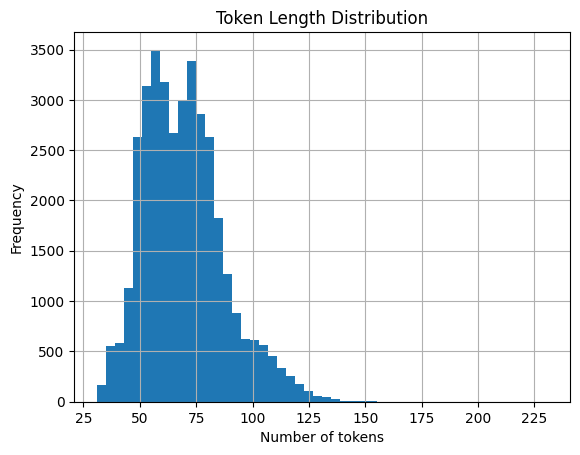

In [ ]:
lengths = [len(tokenizer.encode(t, truncation=False)) for t in train["text"]]
import matplotlib.pyplot as plt

plt.hist(lengths, bins=50)
plt.title("Token Length Distribution")
plt.xlabel("Number of tokens")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [ ]:
L = (np.array(lengths)>MAX_LEN).sum()
print(f"There are {L} train sample(s) with more than {MAX_LEN} tokens")
np.sort( lengths )

There are 0 train sample(s) with more than 256 tokens


array([ 31,  31,  31, ..., 178, 187, 231])

In [ ]:

#from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold


#sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
#tr_idx, va_idx = next(sss.split(train, train["Category"]))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold_idx, (tr_idx, va_idx) in enumerate(skf.split(train, train["label"])):
    if fold_idx == FOLD_TO_TRAIN:
        break

train_df = train.iloc[tr_idx].copy().reset_index(drop=True)
val_df = train.iloc[va_idx].copy().reset_index(drop=True)


In [ ]:
# Convert to Hugging Face Dataset
COLS = ['text','label']
train_ds = Dataset.from_pandas(train_df[COLS])
val_ds = Dataset.from_pandas(val_df[COLS])

In [ ]:
# Tokenization function
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)

# Set format for PyTorch
columns = ['input_ids', 'attention_mask', 'label']
train_ds.set_format(type='torch', columns=columns)
val_ds.set_format(type='torch', columns=columns)

Map:   0%|          | 0/29356 [00:00<?, ? examples/s]

Map:   0%|          | 0/7340 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=n_classes,
    dtype="bfloat16",
    reference_compile=False,
)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at /content/jhu-clsp/ettin-encoder-1b and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir = f"./{DIR}",
    do_train=True,
    do_eval=True,
    eval_strategy="steps",
    save_strategy="steps", #no for no saving
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=16*2,
    per_device_eval_batch_size=32*2,
    #learning_rate=5e-5,
    learning_rate=5e-5,
    weight_decay=0.02,
    warmup_ratio=0.06,
    #label_smoothing_factor=0.05,
    lr_scheduler_type="cosine",
    logging_dir="./logs",
    logging_steps=50,
    save_steps=200,
    eval_steps=200,
    save_total_limit=1,
    metric_for_best_model="map@3",
    greater_is_better=True,
    load_best_model_at_end=True,
    report_to="none",
    bf16=True,
    fp16=False,
)

In [ ]:
# CUSTOM MAP@3 METRIC

from sklearn.metrics import average_precision_score

def compute_map3(eval_pred):
    logits, labels = eval_pred
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()

    top3 = np.argsort(-probs, axis=1)[:, :3]  # Top 3 predictions
    match = (top3 == labels[:, None])

    # Compute MAP@3 manually
    map3 = 0
    for i in range(len(labels)):
        if match[i, 0]:
            map3 += 1.0
        elif match[i, 1]:
            map3 += 1.0 / 2
        elif match[i, 2]:
            map3 += 1.0 / 3
    return {"map@3": map3 / len(labels)}

In [ ]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_map3,
)

trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': None, 'bos_token_id': None}.


Step,Training Loss,Validation Loss,Map@3
200,0.467600,0.399107,0.926249
400,0.328200,0.290207,0.952770
600,0.205000,0.233897,0.961262
800,0.209800,0.219205,0.963896
1000,0.161200,0.192594,0.966689
1200,0.135800,0.189960,0.969028
1400,0.111300,0.197421,0.969301
1600,0.122600,0.185561,0.969800
1800,0.120600,0.182242,0.970005
2000,0.058100,0.190910,0.970413


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/ver_1_fold3/checkpoint-2200 /content/drive/MyDrive/models

In [ ]:
!zip -r model_fold3.zip /content/drive/MyDrive/models/checkpoint-2600

  adding: content/drive/MyDrive/models/checkpoint-2200/ (stored 0%)
  adding: content/drive/MyDrive/models/checkpoint-2200/config.json (deflated 70%)
  adding: content/drive/MyDrive/models/checkpoint-2200/model.safetensors (deflated 21%)
  adding: content/drive/MyDrive/models/checkpoint-2200/tokenizer_config.json (deflated 95%)
  adding: content/drive/MyDrive/models/checkpoint-2200/special_tokens_map.json (deflated 79%)
  adding: content/drive/MyDrive/models/checkpoint-2200/tokenizer.json (deflated 82%)
  adding: content/drive/MyDrive/models/checkpoint-2200/training_args.bin (deflated 53%)
  adding: content/drive/MyDrive/models/checkpoint-2200/scheduler.pt (deflated 61%)
  adding: content/drive/MyDrive/models/checkpoint-2200/rng_state.pth (deflated 26%)
  adding: content/drive/MyDrive/models/checkpoint-2200/trainer_state.json (deflated 78%)


In [ ]:
#trainer.save_model(f"ver_{VER}")
#tokenizer.save_pretrained(f"ver_{VER}")

In [ ]:
test = pd.read_csv('/content/test.csv')
print( test.shape )
test.head()

(3, 5)


,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation
0,36696,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"I think that 1/3 is the answer, as it's the si..."
1,36697,31772,What fraction of the shape is not shaded? Give...,\( \frac{3}{6} \),i think this answer is because 3 triangles are...
2,36698,32835,Which number is the greatest?,\( 6.2 \),because the 2 makes it higher than the others.


In [ ]:
test = test.merge(correct, on=['QuestionId','MC_Answer'], how='left')
test.is_correct = test.is_correct.fillna(0)

test['text'] = test.apply(format_input,axis=1)

test.head()

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,is_correct,text
0,36696,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"I think that 1/3 is the answer, as it's the si...",1.0,Question: What fraction of the shape is not sh...
1,36697,31772,What fraction of the shape is not shaded? Give...,\( \frac{3}{6} \),i think this answer is because 3 triangles are...,0.0,Question: What fraction of the shape is not sh...
2,36698,32835,Which number is the greatest?,\( 6.2 \),because the 2 makes it higher than the others.,1.0,Question: Which number is the greatest?\nAnswe...


In [ ]:
ds_test = Dataset.from_pandas(test[['text']])
ds_test = ds_test.map(tokenize, batched=True)

predictions = trainer.predict(ds_test)
probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

In [ ]:
# Get top 3 predicted class indices
top3 = np.argsort(-probs, axis=1)[:, :3]   # shape: [num_samples, 3]

# Decode numeric class indices to original string labels
flat_top3 = top3.flatten()
decoded_labels = le.inverse_transform(flat_top3)
top3_labels = decoded_labels.reshape(top3.shape)

# Join 3 labels per row with space
joined_preds = [" ".join(row) for row in top3_labels]

# Save submission
sub = pd.DataFrame({
    "row_id": test.row_id.values,
    "Category:Misconception": joined_preds
})
sub.to_csv("submission.csv", index=False)
sub.head()

,row_id,Category:Misconception
0,36696,True_Correct:NA True_Neither:NA True_Misconcep...
1,36697,False_Misconception:WNB False_Neither:NA False...
2,36698,True_Neither:NA True_Correct:NA True_Misconcep...


优化建议

In [ ]:
#多折分割
    #将原本的单次80/20数据分割改为5折交叉验证：用StratifiedKFold将数据分5折（label分），循环训练5个模型，每个模型用4折训练1折验证，最后对5个模型的预测概率取平均得到最终结果。
    #多fold可以保证其中一些非常稀有的类被训练和评估带来不小提升(目前cv + 0.01，lb - 0.001)

#后处理
    #根据规则排除一些不可能选项

#用现有的推理大模型（或小 instruct）在训练集上为每条样本生成 2–3 句「学生为什么会这样错」的简短因果解释，保存成列 cot_hint



#5fold encoder only model(cv = 0.944)

In [ ]:
import os
import gc
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
import warnings
warnings.filterwarnings('ignore')

# ============================================
# PART 1: DOWNLOAD PRETRAINED MODEL
# ============================================
print("=" * 60)
print("STEP 1: Downloading Pretrained Model")
print("=" * 60)

from huggingface_hub import snapshot_download

# Download pretrained model
local_dir = "jhu-clsp/ettin-encoder-1b"
if not os.path.exists(local_dir):
    snapshot_download(
        repo_id="jhu-clsp/ettin-encoder-1b",
        local_dir=local_dir,
        resume_download=True,
        max_workers=4
    )
    print(f"Model downloaded to: {local_dir}")
else:
    print(f"Model already exists at: {local_dir}")

# ============================================
# PART 2: CONFIGURATION
# ============================================
print("\n" + "=" * 60)
print("STEP 2: Configuration")
print("=" * 60)

VER = 1
model_name = local_dir
EPOCHS = 3
NUM_FOLDS = 5
MAX_LEN = 256
BATCH_SIZE = 32  # Adjust based on GPU memory

# Create main directory
MAIN_DIR = f"ver_{VER}_5fold"
os.makedirs(MAIN_DIR, exist_ok=True)
print(f"Output directory: {MAIN_DIR}")

# ============================================
# PART 3: DATA PREPARATION
# ============================================
print("\n" + "=" * 60)
print("STEP 3: Loading and Preparing Data")
print("=" * 60)

# Download data if not exists
if not os.path.exists('train.csv'):
    print("Downloading competition data...")
    os.system('kaggle competitions download -c map-charting-student-math-misunderstandings')
    os.system('unzip -q map-charting-student-math-misunderstandings.zip')

# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

# Prepare labels
le = LabelEncoder()
train['Misconception'] = train['Misconception'].fillna('NA')
train['target'] = train['Category'] + ":" + train['Misconception']
train['label'] = le.fit_transform(train['target'])
n_classes = len(le.classes_)
print(f"Number of target classes: {n_classes}")

# Save label encoder for later use
import pickle
with open(f'{MAIN_DIR}/label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

# Add is_correct feature
idx = train.apply(lambda row: row.Category.split('_')[0], axis=1) == 'True'
correct = train.loc[idx].copy()
correct['c'] = correct.groupby(['QuestionId', 'MC_Answer']).MC_Answer.transform('count')
correct = correct.sort_values('c', ascending=False)
correct = correct.drop_duplicates(['QuestionId'])
correct = correct[['QuestionId', 'MC_Answer']]
correct['is_correct'] = 1

train = train.merge(correct, on=['QuestionId', 'MC_Answer'], how='left')
train['is_correct'] = train['is_correct'].fillna(0)

# Format input function
def format_input(row):
    x = "Yes" if row['is_correct'] else "No"
    return (
        f"Question: {row['QuestionText']}\n"
        f"Answer: {row['MC_Answer']}\n"
        f"Correct? {x}\n"
        f"Student Explanation: {row['StudentExplanation']}"
    )

train['text'] = train.apply(format_input, axis=1)
print("Data preparation complete!")

# ============================================
# PART 4: TRAINING FUNCTIONS
# ============================================
print("\n" + "=" * 60)
print("STEP 4: Defining Training Functions")
print("=" * 60)

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=MAX_LEN)

# MAP@3 metric
def compute_map3(eval_pred):
    logits, labels = eval_pred
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
    top3 = np.argsort(-probs, axis=1)[:, :3]
    match = (top3 == labels[:, None])

    map3 = 0
    for i in range(len(labels)):
        if match[i, 0]:
            map3 += 1.0
        elif match[i, 1]:
            map3 += 1.0 / 2
        elif match[i, 2]:
            map3 += 1.0 / 3
    return {"map@3": map3 / len(labels)}

# ============================================
# PART 5: 5-FOLD CROSS VALIDATION TRAINING
# ============================================
print("\n" + "=" * 60)
print("STEP 5: Starting 5-Fold Cross Validation Training")
print("=" * 60)

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

# Store validation scores
val_scores = []
trained_models = []

# Train each fold
for fold_idx, (tr_idx, va_idx) in enumerate(skf.split(train, train['label'])):
    print(f"\n{'='*50}")
    print(f"Training Fold {fold_idx + 1}/{NUM_FOLDS}")
    print(f"{'='*50}")

    # Create fold directory
    fold_dir = f"{MAIN_DIR}/fold_{fold_idx}"
    os.makedirs(fold_dir, exist_ok=True)

    # Split data
    train_df = train.iloc[tr_idx].copy().reset_index(drop=True)
    val_df = train.iloc[va_idx].copy().reset_index(drop=True)
    print(f"Train: {len(train_df)}, Val: {len(val_df)}")

    # Create datasets
    COLS = ['text', 'label']
    train_ds = Dataset.from_pandas(train_df[COLS])
    val_ds = Dataset.from_pandas(val_df[COLS])

    # Tokenize
    train_ds = train_ds.map(tokenize, batched=True)
    val_ds = val_ds.map(tokenize, batched=True)

    # Set format
    columns = ['input_ids', 'attention_mask', 'label']
    train_ds.set_format(type='torch', columns=columns)
    val_ds.set_format(type='torch', columns=columns)

    # Load model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=n_classes,
        torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
    )

    # Training arguments - save only model weights, not optimizer
    training_args = TrainingArguments(
        output_dir=fold_dir,
        do_train=True,
        do_eval=True,
        eval_strategy="steps",
        save_strategy="steps",
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE*2,
        learning_rate=5e-5,
        weight_decay=0.01,
        warmup_ratio=0.06,
        #label_smoothing_factor=0.05,
        lr_scheduler_type="cosine",
        logging_dir=f"{fold_dir}/logs",
        logging_steps=50,
        save_steps=200,
        eval_steps=200,
        save_total_limit=1,
        metric_for_best_model="map@3",
        greater_is_better=True,
        load_best_model_at_end=True,
        report_to="none",
        bf16=torch.cuda.is_available(),
        fp16=False,
        save_safetensors=True,
        save_only_model=True,  # Don't save optimizer state
    )

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_map3,
    )

    # Train
    train_result = trainer.train()

    # Evaluate
    eval_result = trainer.evaluate()
    val_scores.append(eval_result['eval_map@3'])
    print(f"Fold {fold_idx + 1} MAP@3: {eval_result['eval_map@3']:.4f}")

    # Save only the model weights
    model_save_path = f"{fold_dir}/model.safetensors"
    trainer.save_model(f"{fold_dir}/final_model")
    tokenizer.save_pretrained(f"{fold_dir}/final_model")

    # Clean up
    del model, trainer, train_ds, val_ds
    gc.collect()
    torch.cuda.empty_cache()

# Print summary
print(f"\n{'='*60}")
print("Training Complete - Summary")
print(f"{'='*60}")
for i, score in enumerate(val_scores):
    print(f"Fold {i+1}: MAP@3 = {score:.4f}")
print(f"Average MAP@3: {np.mean(val_scores):.4f} ± {np.std(val_scores):.4f}")

# ============================================
# PART 6: INFERENCE ON TEST SET
# ============================================
print(f"\n{'='*60}")
print("STEP 6: Inference on Test Set")
print(f"{'='*60}")

# Prepare test data
test = test.merge(correct, on=['QuestionId', 'MC_Answer'], how='left')
test['is_correct'] = test['is_correct'].fillna(0)
test['text'] = test.apply(format_input, axis=1)
print(f"Test samples: {len(test)}")

# Create test dataset
ds_test = Dataset.from_pandas(test[['text']])
ds_test = ds_test.map(tokenize, batched=True)
ds_test.set_format(type='torch', columns=['input_ids', 'attention_mask'])

# Collect predictions from all folds
all_fold_probs = []

for fold_idx in range(NUM_FOLDS):
    print(f"\nFold {fold_idx + 1} inference...")

    model_path = f"{MAIN_DIR}/fold_{fold_idx}/final_model"

    # Load model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_path,
        num_labels=n_classes,
        torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
    )
    model.eval()

    if torch.cuda.is_available():
        model = model.cuda()

    # Predict
    fold_probs = []
    with torch.no_grad():
        for i in range(0, len(ds_test), BATCH_SIZE):
            batch_end = min(i + BATCH_SIZE, len(ds_test))
            batch = ds_test[i:batch_end]

            inputs = {
                'input_ids': batch['input_ids'],
                'attention_mask': batch['attention_mask']
            }

            if torch.cuda.is_available():
                inputs = {k: v.cuda() for k, v in inputs.items()}

            outputs = model(**inputs)
            logits = outputs.logits.cpu()
            probs = torch.nn.functional.softmax(logits, dim=-1).numpy()
            fold_probs.extend(probs)

    fold_probs = np.array(fold_probs)
    all_fold_probs.append(fold_probs)

    # Clean up
    del model
    gc.collect()
    torch.cuda.empty_cache()

# ============================================
# PART 7: ENSEMBLE AND CREATE SUBMISSION
# ============================================
print(f"\n{'='*60}")
print("STEP 7: Creating Submission")
print(f"{'='*60}")

# Ensemble predictions
ensemble_probs = np.mean(all_fold_probs, axis=0)
print(f"Ensemble shape: {ensemble_probs.shape}")

# Get top 3 predictions
top3 = np.argsort(-ensemble_probs, axis=1)[:, :3]

# Decode labels
flat_top3 = top3.flatten()
decoded_labels = le.inverse_transform(flat_top3)
top3_labels = decoded_labels.reshape(top3.shape)

# Create submission
joined_preds = [" ".join(row) for row in top3_labels]
sub = pd.DataFrame({
    "row_id": test.row_id.values,
    "Category:Misconception": joined_preds
})

# Save submission
submission_path = f"{MAIN_DIR}/submission.csv"
sub.to_csv(submission_path, index=False)
print(f"Submission saved to: {submission_path}")
print("\nFirst 5 predictions:")
print(sub.head())

print(f"\n{'='*60}")
print("Pipeline Complete!")
print(f"{'='*60}")

#5fold decoder only model(cv = 0.943)

In [ ]:
# ============================================================
# Decoder + Classification Head, 5-Fold CV (Kaggle friendly)
# pad_token/eos、use_cache=False、grad_ckpt、(可选)LoRA
# ============================================================

import os, gc, warnings, pickle, numpy as np, pandas as pd, torch
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset

from huggingface_hub import snapshot_download
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)

# -----------------------------
# Step 0: Repro
# -----------------------------
SEED = 42
def seed_everything(seed):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
seed_everything(SEED)

# ============================================================
# PART 1: (Optional) Download any local assets (not required here)
# ============================================================
print("=" * 60)
print("STEP 1: Setup")
print("=" * 60)

MODEL_NAME = "Qwen/Qwen3-1.7B"

# Kaggle 环境建议起步配置（T4）
VER = 1
NUM_FOLDS = 5
EPOCHS = 2
MAX_LEN = 256
BATCH_SIZE = 8
LR = 5e-5

MAIN_DIR = f"ver_{VER}_5fold_decoder_cls"
os.makedirs(MAIN_DIR, exist_ok=True)
print(f"Output directory: {MAIN_DIR}")

# ============================================================
# PART 2: Load Competition Data
# ============================================================
print("\n" + "=" * 60)
print("STEP 2: Loading Data")
print("=" * 60)

if not os.path.exists('train.csv') or not os.path.exists('test.csv'):
    print("Downloading competition data...")
    os.system('kaggle competitions download -c map-charting-student-math-misunderstandings -p .')
    os.system('unzip -oq map-charting-student-math-misunderstandings.zip')

train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')
print(f"Train shape: {train.shape} | Test shape: {test.shape}")

# ============================================================
# PART 3: Labels & Basic Feature
# ============================================================
print("\n" + "=" * 60)
print("STEP 3: Labels & Features")
print("=" * 60)

train['Misconception'] = train['Misconception'].fillna('NA')
train['target'] = train['Category'] + ":" + train['Misconception']

le = LabelEncoder()
train['label'] = le.fit_transform(train['target'])
n_classes = len(le.classes_)
print(f"Number of target classes: {n_classes}")

with open(f'{MAIN_DIR}/label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

# 注入 True/False 先验（与您之前一致）
idx = train.apply(lambda row: row.Category.split('_')[0], axis=1) == 'True'
correct = train.loc[idx].copy()
correct['c'] = correct.groupby(['QuestionId', 'MC_Answer']).MC_Answer.transform('count')
correct = correct.sort_values('c', ascending=False)
correct = correct.drop_duplicates(['QuestionId'])
correct = correct[['QuestionId', 'MC_Answer']]
correct['is_correct'] = 1

train = train.merge(correct, on=['QuestionId', 'MC_Answer'], how='left')
train['is_correct'] = train['is_correct'].fillna(0)

def format_input(row):
    x = "This answer is correct." if row['is_correct'] else "This answer is incorrect."
    return (
        f"Question: {row['QuestionText']}\n"
        f"Answer: {row['MC_Answer']}\n"
        f"{x}\n"
        f"Student Explanation: {row['StudentExplanation']}"
    )

train['text'] = train.apply(format_input, axis=1)

print("Data prep done.")

# ============================================================
# PART 4: Tokenizer (关键改动：pad_token = eos_token)
# ============================================================
print("\n" + "=" * 60)
print("STEP 4: Tokenizer (decoder-only essentials)")
print("=" * 60)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token   #decoder-only 必需
print(f"pad_token_id={tokenizer.pad_token_id}, eos_token_id={tokenizer.eos_token_id}")

def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN,
    )

# ============================================================
# PART 5: Metric
# ============================================================
def compute_map3(eval_pred):
    logits, labels = eval_pred
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
    top3 = np.argsort(-probs, axis=1)[:, :3]
    match = (top3 == labels[:, None])

    map3 = 0.0
    for i in range(len(labels)):
        if match[i, 0]:
            map3 += 1.0
        elif match[i, 1]:
            map3 += 0.5
        elif match[i, 2]:
            map3 += 1.0/3
    return {"map@3": map3 / len(labels)}

# ============================================================
# PART 6: 5-Fold Training
# （关键改动：decoder-only + 分类头、use_cache=False、grad_ckpt）
# ============================================================
print("\n" + "=" * 60)
print("STEP 5: 5-Fold Training")
print("=" * 60)

skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED)
val_scores = []

#LoRA 开关
USE_LORA = False  # 先跑稳，再开 True
LORA_R = 16
LORA_ALPHA = 32
LORA_DROPOUT = 0.05
LORA_TARGET = ["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"]  # Qwen/LLaMA 常见

def build_model():
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=n_classes,
        torch_dtype=(torch.bfloat16 if torch.cuda.is_available() else torch.float32),
    )
    # 关键：pad_token / use_cache
    model.config.pad_token_id = tokenizer.pad_token_id
    if hasattr(model.config, "use_cache"):
        model.config.use_cache = False        # 配合梯度检查点
    model.config.problem_type = "single_label_classification"

    if USE_LORA:
        from peft import LoraConfig, get_peft_model, TaskType
        peft_cfg = LoraConfig(
            task_type=TaskType.SEQ_CLS,         # 分类任务
            r=LORA_R, lora_alpha=LORA_ALPHA, lora_dropout=LORA_DROPOUT,
            target_modules=LORA_TARGET,
            bias="none",
        )
        model = get_peft_model(model, peft_cfg)
        try:
            model.print_trainable_parameters()
        except:
            pass
    return model

for fold, (tr_idx, va_idx) in enumerate(skf.split(train, train['label'])):
    print(f"\n{'='*50}\nFold {fold+1}/{NUM_FOLDS}\n{'='*50}")

    fold_dir = f"{MAIN_DIR}/fold_{fold}"
    os.makedirs(fold_dir, exist_ok=True)

    train_df = train.iloc[tr_idx].reset_index(drop=True)
    val_df   = train.iloc[va_idx].reset_index(drop=True)
    print(f"Train={len(train_df)} | Val={len(val_df)}")

    # Datasets
    train_ds = Dataset.from_pandas(train_df[['text','label']]).map(tokenize_fn, batched=True)
    val_ds   = Dataset.from_pandas(val_df[['text','label']]).map(tokenize_fn, batched=True)
    cols = ['input_ids','attention_mask','label']
    train_ds.set_format(type='torch', columns=cols)
    val_ds.set_format(type='torch', columns=cols)

    # Model
    model = build_model()

    # Device/bf16 选择
    use_bf16 = torch.cuda.is_available() and torch.cuda.get_device_properties(0).major >= 8  # A100+
    training_args = TrainingArguments(
        output_dir=fold_dir,
        do_train=True, do_eval=True,
        eval_strategy="steps",      #  与 save_strategy 保持一致
        save_strategy="steps",
        eval_steps=200,
        save_steps=200,
        gradient_accumulation_steps = 4,
        save_total_limit=1,
        metric_for_best_model="map@3",
        greater_is_better=True,
        load_best_model_at_end=True,

        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE*2,
        learning_rate=LR,
        weight_decay=0.01,
        warmup_ratio=0.06,
        lr_scheduler_type="cosine",

        logging_dir=f"{fold_dir}/logs",
        logging_steps=50,
        report_to="none",

        bf16=use_bf16,
        fp16=not use_bf16,

        save_safetensors=True,
        save_only_model=True,

        gradient_checkpointing=True,
        optim="adamw_torch_fused",
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_map3,
    )

    trainer.train()
    eval_res = trainer.evaluate()
    print(f"Fold {fold+1} MAP@3: {eval_res.get('eval_map@3', -1):.4f}")
    val_scores.append(eval_res.get('eval_map@3', -1))

    # 保存最佳模型与分词器
    trainer.save_model(f"{fold_dir}/final_model")
    tokenizer.save_pretrained(f"{fold_dir}/final_model")

    # 清理
    del model, trainer, train_ds, val_ds
    gc.collect(); torch.cuda.empty_cache()

print("\n" + "=" * 60)
print("Training Summary")
print("=" * 60)
for i, s in enumerate(val_scores, 1):
    print(f"Fold {i}: MAP@3 = {s:.4f}")
print(f"Average MAP@3: {np.mean(val_scores):.4f} ± {np.std(val_scores):.4f}")

# ============================================================
# PART 7: Inference + Ensemble
# ============================================================
print("\n" + "=" * 60)
print("STEP 6: Inference on Test and Submission")
print("=" * 60)

# test 注入 is_correct 与格式
test = test.merge(correct, on=['QuestionId', 'MC_Answer'], how='left')
test['is_correct'] = test['is_correct'].fillna(0)
test['text'] = test.apply(format_input, axis=1)

ds_test = Dataset.from_pandas(test[['text']]).map(tokenize_fn, batched=True)
ds_test.set_format(type='torch', columns=['input_ids','attention_mask'])

all_fold_probs = []

for fold in range(NUM_FOLDS):
    print(f"Fold {fold+1} inference...")
    model_path = f"{MAIN_DIR}/fold_{fold}/final_model"
    model = AutoModelForSequenceClassification.from_pretrained(
        model_path,
        num_labels=n_classes,
        torch_dtype=(torch.bfloat16 if torch.cuda.is_available() else torch.float32),
    )
    model.config.pad_token_id = tokenizer.pad_token_id
    if hasattr(model.config, "use_cache"):
        model.config.use_cache = False
    model.eval()
    if torch.cuda.is_available():
        model = model.cuda()

    probs_list = []
    with torch.no_grad():
        for i in range(0, len(ds_test), BATCH_SIZE):
            j = min(i+BATCH_SIZE, len(ds_test))
            batch = ds_test[i:j]
            inputs = {
                "input_ids": batch["input_ids"],
                "attention_mask": batch["attention_mask"],
            }
            if torch.cuda.is_available():
                inputs = {k: v.cuda() for k, v in inputs.items()}
            logits = model(**inputs).logits.detach().cpu()
            probs = torch.nn.functional.softmax(logits, dim=-1).numpy()
            probs_list.append(probs)

    fold_probs = np.vstack(probs_list)
    all_fold_probs.append(fold_probs)

    del model
    gc.collect(); torch.cuda.empty_cache()

ensemble_probs = np.mean(all_fold_probs, axis=0)
top3 = np.argsort(-ensemble_probs, axis=1)[:, :3]

flat = top3.flatten()
decoded = le.inverse_transform(flat).reshape(top3.shape)
joined = [" ".join(row) for row in decoded]

sub = pd.DataFrame({
    "row_id": test.row_id.values,
    "Category:Misconception": joined
})

sub_path = f"{MAIN_DIR}/submission.csv"
sub.to_csv(sub_path, index=False)
print(f"Submission saved to: {sub_path}")
print(sub.head())
print("\nDone.")
